# Problem - Statement

## About Yulu

Yulu is India’s leading micro-mobility service provider, offering unique vehicles for daily commutes. With a mission to eliminate traffic congestion in India, Yulu provides a safe and user-friendly mobile app to enable shared, solo, and sustainable commuting. Yulu zones are strategically located at key locations including metro stations, bus stands, office spaces, residential areas, and corporate offices, ensuring smooth, affordable, and convenient first and last-mile connectivity.

## Business Challenge

Recently, Yulu has experienced significant dips in its revenues. To address this issue, Yulu has engaged a consulting company to understand the factors influencing the demand for its shared electric cycles in the Indian market. Specifically, Yulu aims to identify the key variables that significantly impact the demand and how these variables can help predict future demand.

## How you can help here?

The company wants to know:

1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
2. How well those variables describe the electric cycle demands?

# Module Imports and Dataset

## Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats

## Datasets

In [2]:
df = pd.read_csv('yulu.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**`Columns Description`**

| Column     | Description                                                                           |
|------------|---------------------------------------------------------------------------------------|
| `datetime` | datetime                                                                              |
| **`season`**   | **season (1: spring, 2: summer, 3: fall, 4: winter)**                                 |
| `holiday`  | whether day is a holiday or not (extracted from [holiday schedule](http://dchr.dc.gov/page/holiday-schedule)) |
| `workingday`| if day is neither weekend nor holiday is 1, otherwise is 0.                           |
| `weather`  | 1: Clear, Few clouds, partly cloudy, partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| `temp`     | temperature in Celsius                                                                |
| `atemp`    | feeling temperature in Celsius                                                        |
| `humidity` | humidity                                                                              |
| `windspeed`| wind speed                                                                            |
| `casual`   | count of casual users                                                                 |
| `registered`| count of registered users                                                            |
| `count`    | count of total rental bikes including both casual and registered                    |


# Data Cleaning and Preprocessing

## Basic Checks

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.shape

(10886, 12)

In [5]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
df.duplicated().sum()

0

- No missing values are there.
- No duplicates are there.

In [7]:
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

- season, holiday, workingday and weather are the features that have 4, 2, 2 and 4 distinct values.
- So, these columns are categorical columns (and hence these features should be converted to categorical dtype).
- temp, atemp, humidity, windspeed, casual, registered, count are continous numerical features.

In [8]:
categorical_features = ['season', 'holiday', 'workingday', 'weather']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [9]:
for feature in categorical_features:
    df[feature] = pd.Categorical(df[feature])

## Extracting time components
- *Converting datetime to pandas datetime format and Extracting time components*

In [10]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [11]:
first_date, last_date = np.min(df['datetime']), np.max(df['datetime'])
first_date, last_date

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

- Date is available for almost 2 full years (2011, 2012)

In [12]:
df['year'] = pd.Categorical(df['datetime'].dt.year)
df['month'] = pd.Categorical(df['datetime'].dt.month)
df['week'] = pd.Categorical(df['datetime'].dt.isocalendar()['week'])
df['week_day'] = pd.Categorical(df['datetime'].dt.weekday)
df['hour'] = pd.Categorical(df['datetime'].dt.hour)

In [13]:
def categorize_hour(hour: int) -> str:
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

In [14]:
df['time_of_day'] = df['hour'].apply(categorize_hour)

In [15]:
time_components = ['year', 'month', 'week', 'week_day', 'hour', 'time_of_day']

## Miscellaneous Checks

- Given Dataset is sanitized and useful features has been extracted.
- So, EDA can be started.

# EDA

## Basic Checks

### shape, info() and describe() etc

In [16]:
df.shape

(10886, 18)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     10886 non-null  datetime64[ns]
 1   season       10886 non-null  category      
 2   holiday      10886 non-null  category      
 3   workingday   10886 non-null  category      
 4   weather      10886 non-null  category      
 5   temp         10886 non-null  float64       
 6   atemp        10886 non-null  float64       
 7   humidity     10886 non-null  int64         
 8   windspeed    10886 non-null  float64       
 9   casual       10886 non-null  int64         
 10  registered   10886 non-null  int64         
 11  count        10886 non-null  int64         
 12  year         10886 non-null  category      
 13  month        10886 non-null  category      
 14  week         10886 non-null  category      
 15  week_day     10886 non-null  category      
 16  hour

In [18]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


In [19]:
df[categorical_features + time_components].describe().T

,count,unique,top,freq
season,10886,4,4,2734
holiday,10886,2,0,10575
workingday,10886,2,1,7412
weather,10886,4,1,7192
year,10886,2,2012,5464
month,10886,12,5,912
week,10886,46,27,336
week_day,10886,7,5,1584
hour,10886,24,12,456
time_of_day,10886,4,Night,4508


### value_counts()

In [20]:
for feature in categorical_features:
    print(df[feature].value_counts())
    print('--------------------------------')

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
--------------------------------
0    10575
1      311
Name: holiday, dtype: int64
--------------------------------
1    7412
0    3474
Name: workingday, dtype: int64
--------------------------------
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
--------------------------------


In [21]:
df['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [22]:
df['month'].value_counts()

5     912
6     912
7     912
8     912
12    912
10    911
11    911
4     909
9     909
2     901
3     901
1     884
Name: month, dtype: int64

In [23]:
df['week_day'].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: week_day, dtype: int64

In [24]:
df['time_of_day'].value_counts()

Night        4508
Morning      2730
Afternoon    1824
Evening      1824
Name: time_of_day, dtype: int64

### Insights :-
1. There are 10886 rows.

## Box Plots and Histograms

### Utility functions

In [25]:
# Function to find ouliers using IQR method
def findOutliersCount(series: pd.Series) -> int:
    q1 = np.quantile(series, 0.25)
    q3 = np.quantile(series, 0.75)

    iqr = q3 - q1

    outliers = series[~((q1 - 1.5*iqr <= series) & (series <= q3 + 1.5*iqr))]
    return len(outliers)

### of temp

Text(0.5, 1.0, 'Histogram of temp recorded')

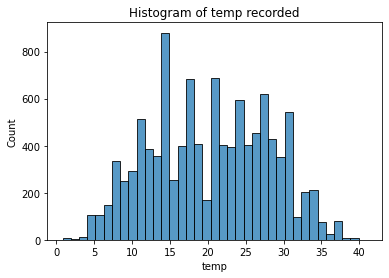

In [26]:
feature = "temp"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

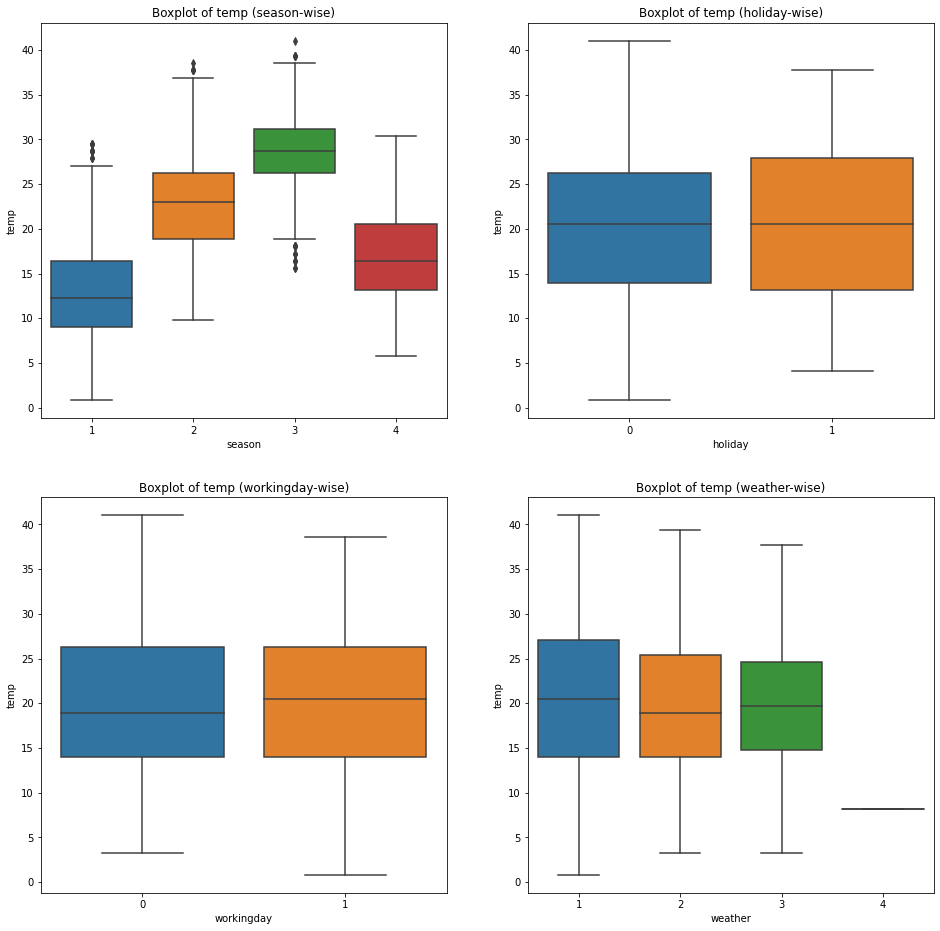

In [27]:
feature = "temp"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of temp (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of temp (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of temp (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of temp (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [28]:
for season in df['season'].unique():
    temp = df.loc[df['season'] == season]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"Season {season} has {numOutliers} outliers of temp feature")

Season 1 has 17 outliers of temp feature
Season 2 has 8 outliers of temp feature
Season 3 has 23 outliers of temp feature
Season 4 has 0 outliers of temp feature


In [29]:
for holiday in df['holiday'].unique():
    temp = df.loc[df['holiday'] == holiday]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"holiday {holiday} has {numOutliers} outliers of temp feature")

holiday 0 has 0 outliers of temp feature
holiday 1 has 0 outliers of temp feature


In [30]:
for workingday in df['workingday'].unique():
    temp = df.loc[df['workingday'] == workingday]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"workingday {workingday} has {numOutliers} outliers of temp feature")

workingday 0 has 0 outliers of temp feature
workingday 1 has 0 outliers of temp feature


In [31]:
for weather in df['weather'].unique():
    temp = df.loc[df['weather'] == weather]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"weather {weather} has {numOutliers} outliers of temp feature")

weather 1 has 0 outliers of temp feature
weather 2 has 0 outliers of temp feature
weather 3 has 0 outliers of temp feature
weather 4 has 0 outliers of temp feature


### of atemp

Text(0.5, 1.0, 'Histogram of atemp recorded')

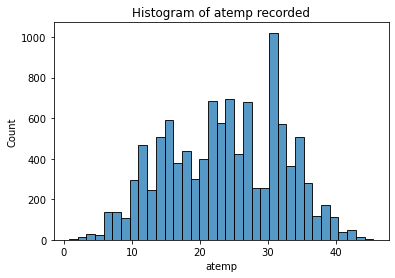

In [32]:
feature = "atemp"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

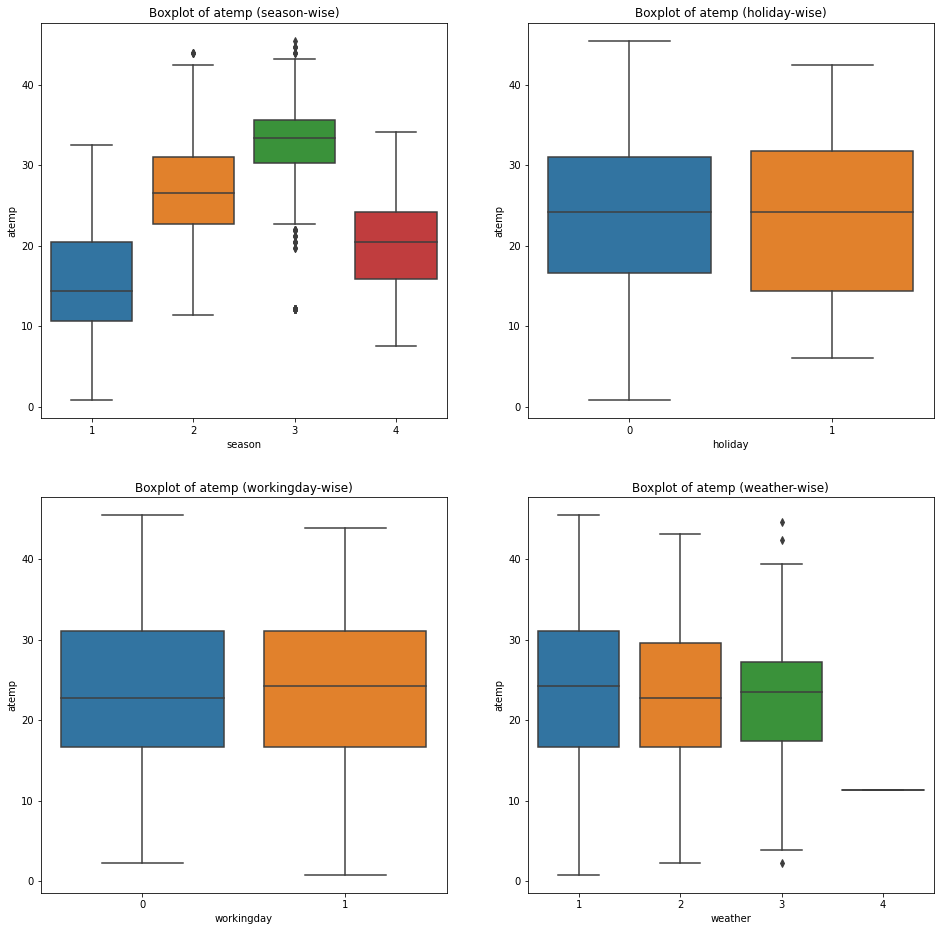

In [33]:
feature = "atemp"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of atemp (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of atemp (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of atemp (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of atemp (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [34]:
for season in df['season'].unique():
    atemp = df.loc[df['season'] == season]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"Season {season} has {numOutliers} outliers of atemp feature")

Season 1 has 0 outliers of atemp feature
Season 2 has 4 outliers of atemp feature
Season 3 has 47 outliers of atemp feature
Season 4 has 0 outliers of atemp feature


In [35]:
for holiday in df['holiday'].unique():
    atemp = df.loc[df['holiday'] == holiday]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"holiday {holiday} has {numOutliers} outliers of atemp feature")

holiday 0 has 0 outliers of atemp feature
holiday 1 has 0 outliers of atemp feature


In [36]:
for workingday in df['workingday'].unique():
    atemp = df.loc[df['workingday'] == workingday]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"workingday {workingday} has {numOutliers} outliers of atemp feature")

workingday 0 has 0 outliers of atemp feature
workingday 1 has 0 outliers of atemp feature


In [37]:
for weather in df['weather'].unique():
    atemp = df.loc[df['weather'] == weather]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"weather {weather} has {numOutliers} outliers of atemp feature")

weather 1 has 0 outliers of atemp feature
weather 2 has 0 outliers of atemp feature
weather 3 has 3 outliers of atemp feature
weather 4 has 0 outliers of atemp feature


### of windspeed

Text(0.5, 1.0, 'Histogram of windspeed recorded')

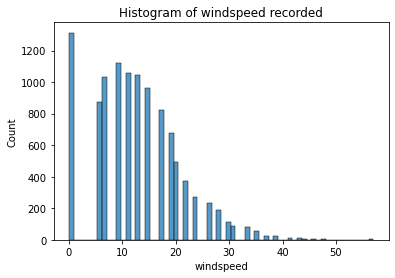

In [38]:
feature = "windspeed"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

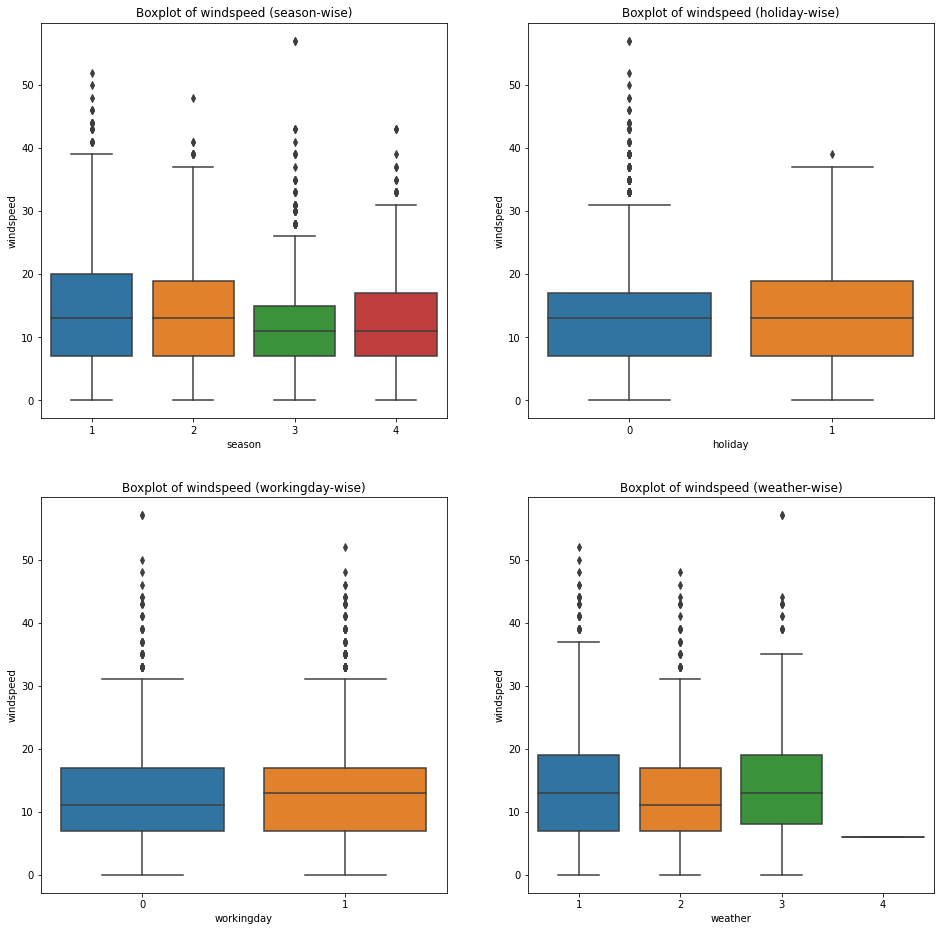

In [39]:
feature = "windspeed"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of windspeed (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of windspeed (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of windspeed (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of windspeed (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [40]:
for season in df['season'].unique():
    windspeed = df.loc[df['season'] == season]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"Season {season} has {numOutliers} outliers of windspeed feature")

Season 1 has 28 outliers of windspeed feature
Season 2 has 12 outliers of windspeed feature
Season 3 has 69 outliers of windspeed feature
Season 4 has 23 outliers of windspeed feature


In [41]:
for holiday in df['holiday'].unique():
    windspeed = df.loc[df['holiday'] == holiday]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"holiday {holiday} has {numOutliers} outliers of windspeed feature")

holiday 0 has 221 outliers of windspeed feature
holiday 1 has 1 outliers of windspeed feature


In [42]:
for workingday in df['workingday'].unique():
    windspeed = df.loc[df['workingday'] == workingday]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"workingday {workingday} has {numOutliers} outliers of windspeed feature")

workingday 0 has 70 outliers of windspeed feature
workingday 1 has 157 outliers of windspeed feature


In [43]:
for weather in df['weather'].unique():
    windspeed = df.loc[df['weather'] == weather]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"weather {weather} has {numOutliers} outliers of windspeed feature")

weather 1 has 34 outliers of windspeed feature
weather 2 has 39 outliers of windspeed feature
weather 3 has 18 outliers of windspeed feature
weather 4 has 0 outliers of windspeed feature


### of humidity

Text(0.5, 1.0, 'Histogram of humidity recorded')

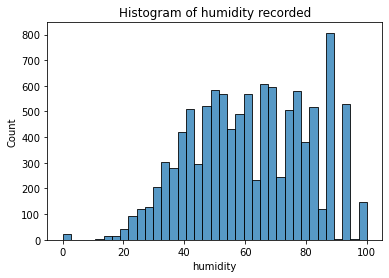

In [44]:
feature = "humidity"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

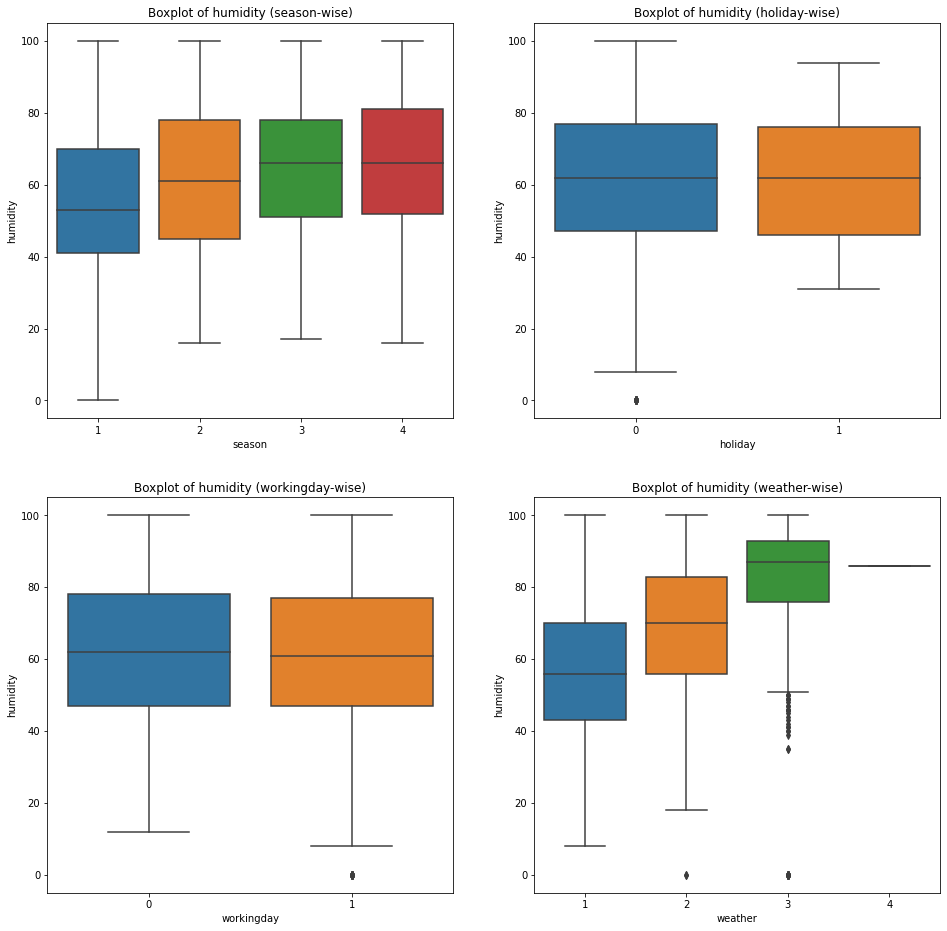

In [45]:
feature = "humidity"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of humidity (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of humidity (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of humidity (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of humidity (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [46]:
for season in df['season'].unique():
    humidity = df.loc[df['season'] == season]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"Season {season} has {numOutliers} outliers of humidity feature")

Season 1 has 0 outliers of humidity feature
Season 2 has 0 outliers of humidity feature
Season 3 has 0 outliers of humidity feature
Season 4 has 0 outliers of humidity feature


In [47]:
for holiday in df['holiday'].unique():
    humidity = df.loc[df['holiday'] == holiday]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"holiday {holiday} has {numOutliers} outliers of humidity feature")

holiday 0 has 22 outliers of humidity feature
holiday 1 has 0 outliers of humidity feature


In [48]:
for workingday in df['workingday'].unique():
    humidity = df.loc[df['workingday'] == workingday]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"workingday {workingday} has {numOutliers} outliers of humidity feature")

workingday 0 has 0 outliers of humidity feature
workingday 1 has 22 outliers of humidity feature


In [49]:
for weather in df['weather'].unique():
    humidity = df.loc[df['weather'] == weather]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"weather {weather} has {numOutliers} outliers of humidity feature")

weather 1 has 0 outliers of humidity feature
weather 2 has 2 outliers of humidity feature
weather 3 has 44 outliers of humidity feature
weather 4 has 0 outliers of humidity feature


### of Count

Text(0.5, 1.0, 'Histogram of count recorded')

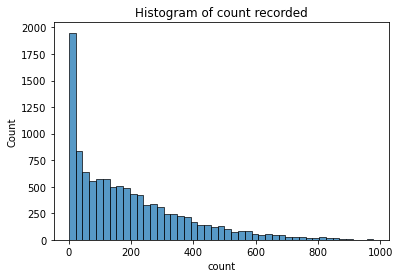

In [50]:
feature = "count"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

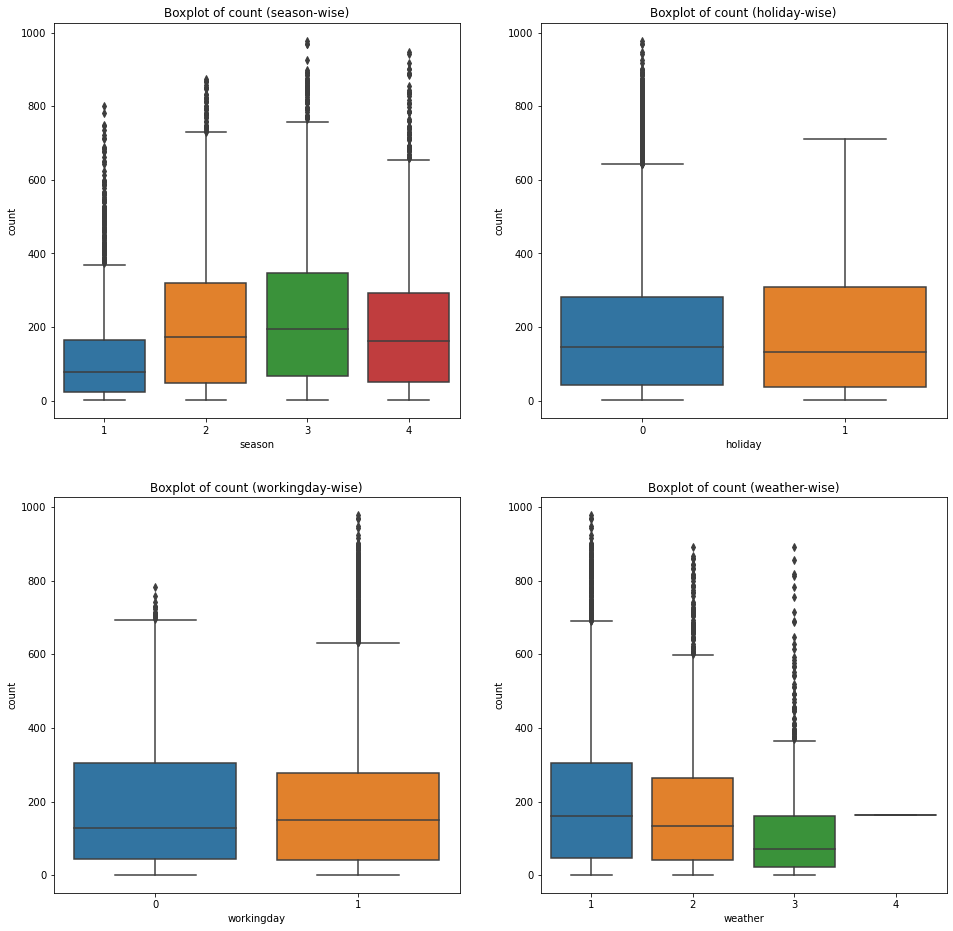

In [51]:
feature = "count"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of count (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of count (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of count (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of count (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [52]:
for season in df['season'].unique():
    count = df.loc[df['season'] == season]["count"]
    numOutliers = findOutliersCount(count)
    print(f"Season {season} has {numOutliers} outliers of count feature")

Season 1 has 139 outliers of count feature
Season 2 has 42 outliers of count feature
Season 3 has 61 outliers of count feature
Season 4 has 64 outliers of count feature


In [53]:
for holiday in df['holiday'].unique():
    count = df.loc[df['holiday'] == holiday]["count"]
    numOutliers = findOutliersCount(count)
    print(f"holiday {holiday} has {numOutliers} outliers of count feature")

holiday 0 has 311 outliers of count feature
holiday 1 has 0 outliers of count feature


In [54]:
for workingday in df['workingday'].unique():
    count = df.loc[df['workingday'] == workingday]["count"]
    numOutliers = findOutliersCount(count)
    print(f"workingday {workingday} has {numOutliers} outliers of count feature")

workingday 0 has 16 outliers of count feature
workingday 1 has 278 outliers of count feature


In [55]:
for weather in df['weather'].unique():
    count = df.loc[df['weather'] == weather]["count"]
    numOutliers = findOutliersCount(count)
    print(f"weather {weather} has {numOutliers} outliers of count feature")

weather 1 has 160 outliers of count feature
weather 2 has 82 outliers of count feature
weather 3 has 56 outliers of count feature
weather 4 has 0 outliers of count feature


1. There are large number of outliers for count feature with respect to other categorical features.
2. Since these outliers captures the essence of data, I am not removing these.

## Group By Analysis

In [56]:
agg_dict = {
    'temp': 'mean',
    'atemp': 'mean',
    'humidity': 'mean',
    'windspeed': 'mean',

    'casual': 'sum',
    'registered': 'sum',
    'count': 'sum'
}

### Group by season

In [57]:
grouping_feature = "season"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,season,temp,atemp,humidity,windspeed,casual,registered,count
0,1,12.530491,15.228956,56.297841,14.636978,41605,270893,312498
1,2,22.823483,26.647098,60.852909,13.405607,129672,458610,588282
2,3,28.789111,32.540783,64.123674,11.508862,142718,497944,640662
3,4,16.649239,20.059909,66.173738,11.678147,78140,465894,544034


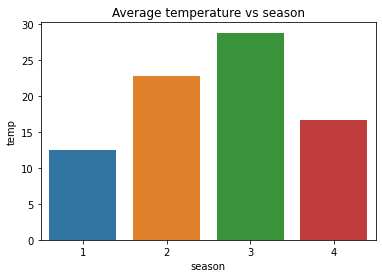

In [58]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

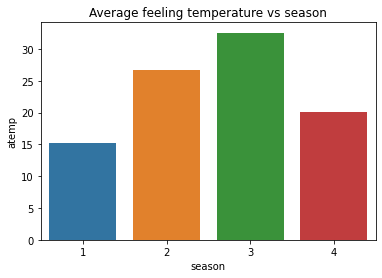

In [59]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

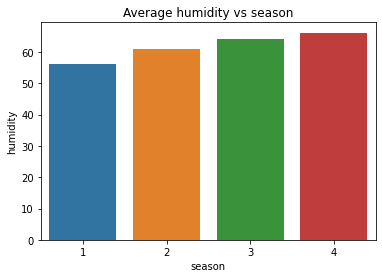

In [60]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

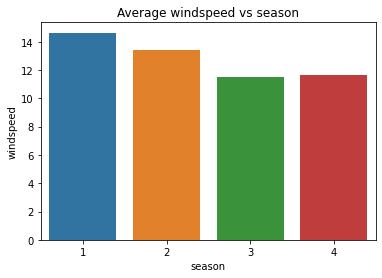

In [61]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

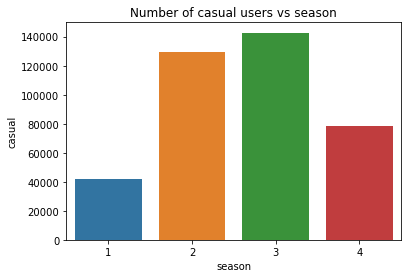

In [62]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

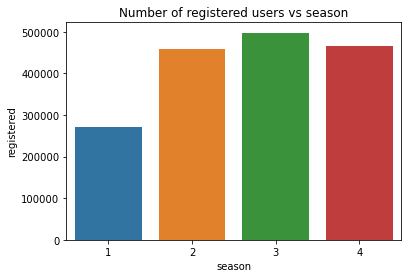

In [63]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

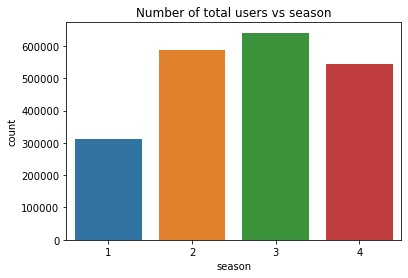

In [64]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by holiday

In [65]:
grouping_feature = "holiday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,holiday,temp,atemp,humidity,windspeed,casual,registered,count
0,0,20.230466,23.662662,61.880095,12.787623,376964,1650704,2027668
1,1,20.244244,23.397395,62.102894,13.199711,15171,42637,57808


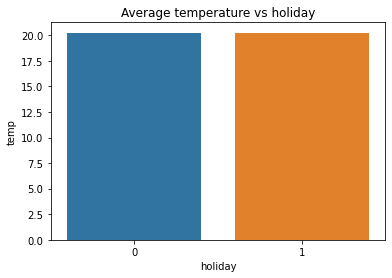

In [66]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

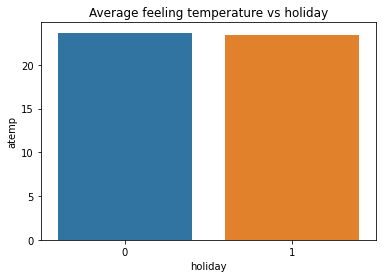

In [67]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

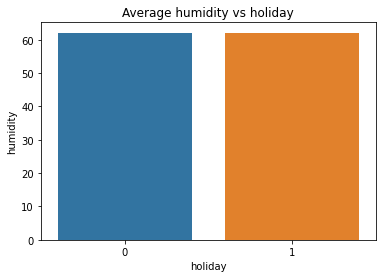

In [68]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

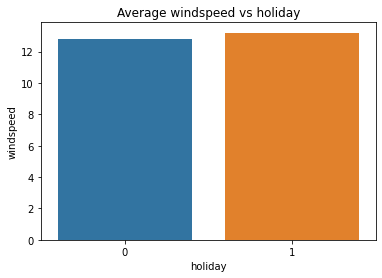

In [69]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

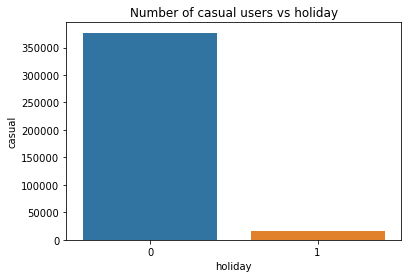

In [70]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

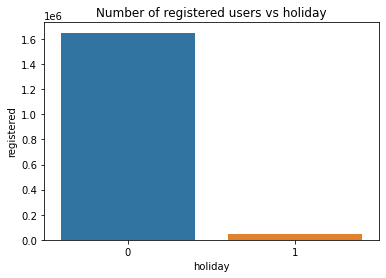

In [71]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

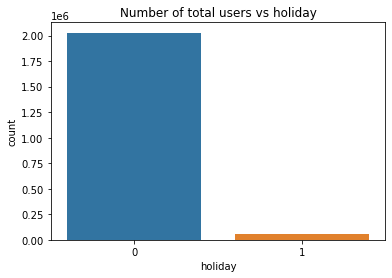

In [72]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by workingday

In [73]:
grouping_feature = "workingday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,workingday,temp,atemp,humidity,windspeed,casual,registered,count
0,0,19.889839,23.349837,62.192286,12.639916,206037,448835,654872
1,1,20.390696,23.798153,61.743119,12.874143,186098,1244506,1430604


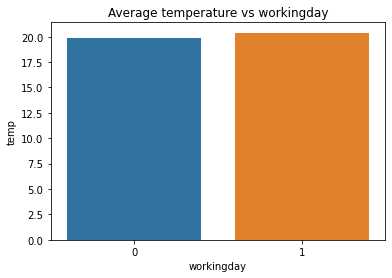

In [74]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

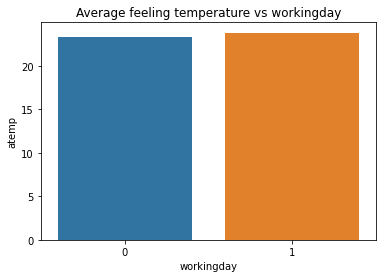

In [75]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

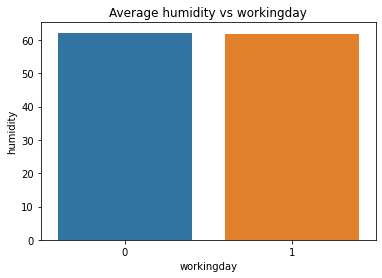

In [76]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

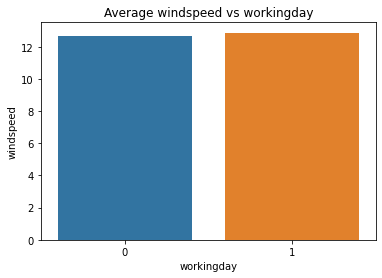

In [77]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

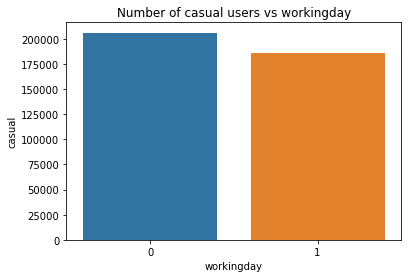

In [78]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

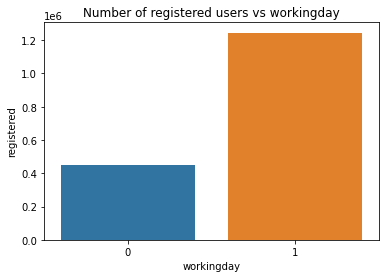

In [79]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

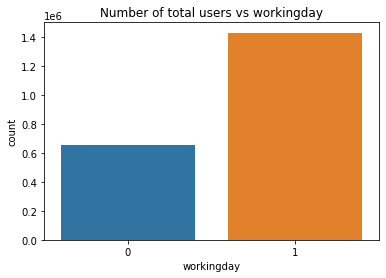

In [80]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by weather

In [81]:
grouping_feature = "weather"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,20.557122,23.994126,56.716769,12.892542,289900,1186163,1476063
1,2,19.614608,23.072414,69.100565,12.179905,87246,419914,507160
2,3,19.546356,22.753091,81.341094,14.071248,14983,87106,102089
3,4,8.200000,11.365000,86.000000,6.003200,6,158,164


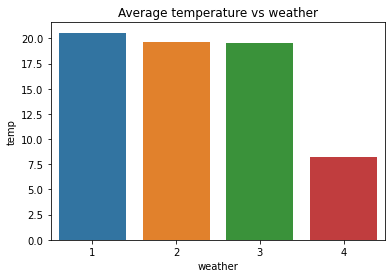

In [82]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

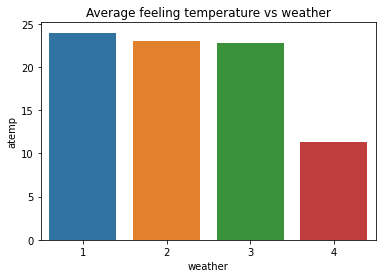

In [83]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

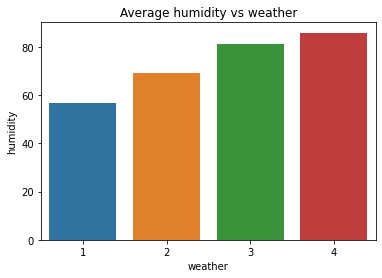

In [84]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

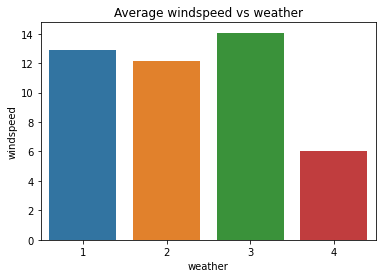

In [85]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

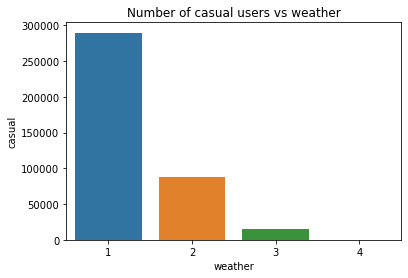

In [86]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

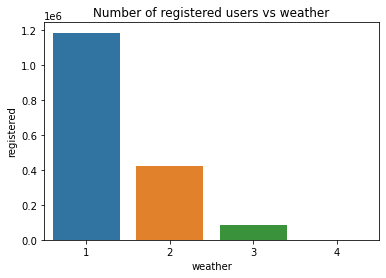

In [87]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

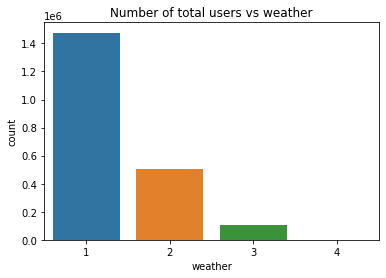

In [88]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by year

In [89]:
grouping_feature = "year"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,year,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,19.751988,23.157086,63.405017,12.924144,155817,626162,781979
1,2012,20.706051,24.149254,60.379575,12.675605,236318,1067179,1303497


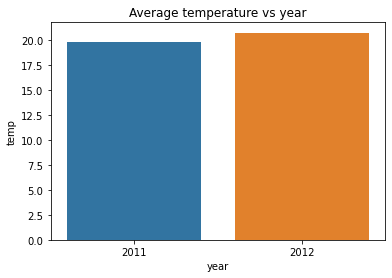

In [90]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

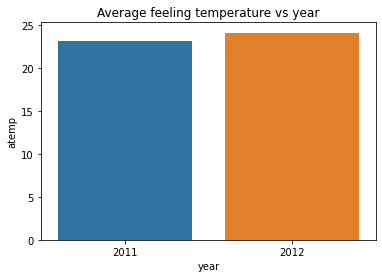

In [91]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

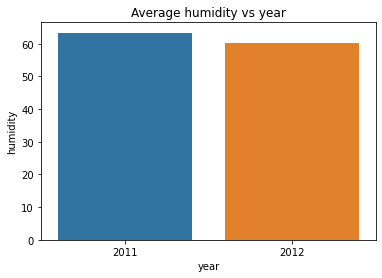

In [92]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

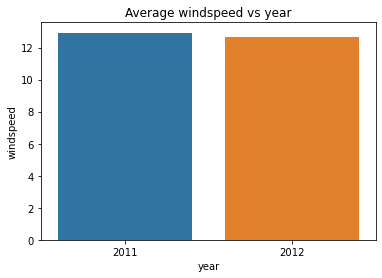

In [93]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

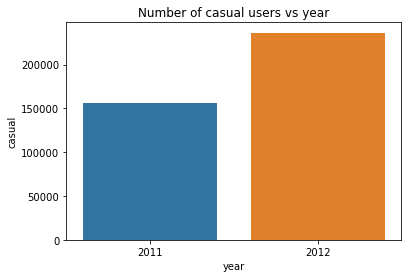

In [94]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

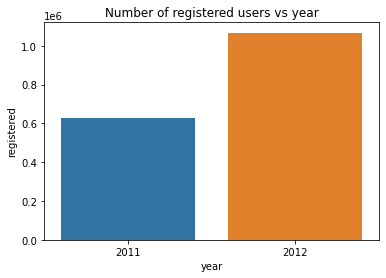

In [95]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

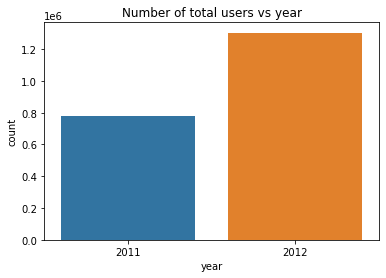

In [96]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by month

In [97]:
grouping_feature = "month"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,month,temp,atemp,humidity,windspeed,casual,registered,count
0,1,9.840000,12.077579,55.911765,14.582959,7252,72632,79884
1,2,11.798535,14.532608,56.296337,13.963707,9297,89816,99113
2,3,15.902175,19.017220,56.678135,15.363249,25056,108445,133501
3,4,18.718372,22.305891,55.697470,15.581090,39813,127589,167402
4,5,22.674079,26.632374,68.084430,12.293956,41285,158862,200147
5,6,27.064496,30.988750,58.759868,12.348930,48574,172159,220733
6,7,30.841711,34.900395,58.402412,11.019928,50947,163670,214617
7,8,29.736689,33.122001,63.010965,11.931179,45870,167646,213516
8,9,25.779032,29.590248,70.980198,11.575698,45901,166628,212529
9,10,20.933853,24.739682,69.412733,11.226457,38087,169347,207434


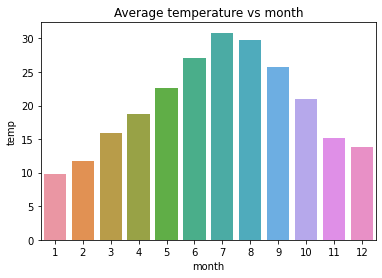

In [98]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

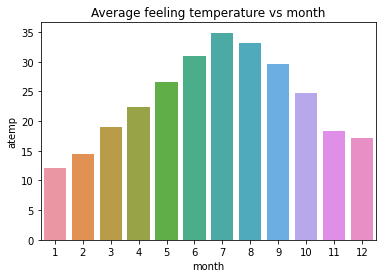

In [99]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

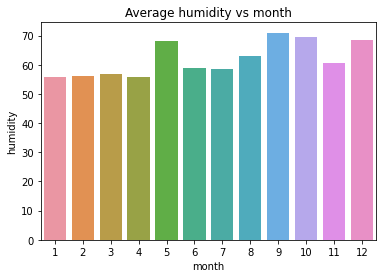

In [100]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

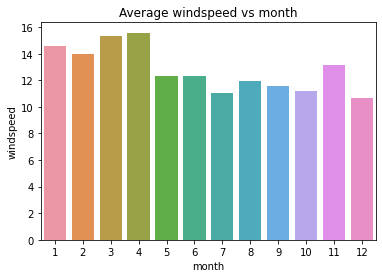

In [101]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

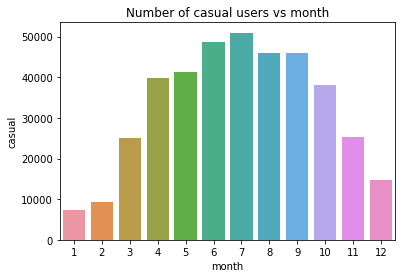

In [102]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

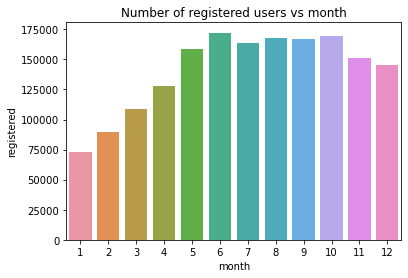

In [103]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

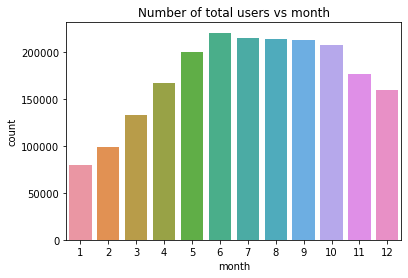

In [104]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by week_day

In [105]:
grouping_feature = "week_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,week_day,temp,atemp,humidity,windspeed,casual,registered,count
0,0,20.620542,24.178507,62.508059,12.921691,46288,249008,295296
1,1,20.732307,24.252898,63.662768,13.338829,35365,256620,291985
2,2,20.323417,23.764271,64.299162,12.635379,34931,257295,292226
3,3,20.251835,23.641465,58.397939,13.138079,37283,269118,306401
4,4,19.993198,23.066609,59.913015,12.398527,47402,255102,302504
5,5,19.668611,23.121266,61.253157,12.670136,100782,210736,311518
6,6,20.041963,23.569766,63.151995,12.499344,90084,195462,285546


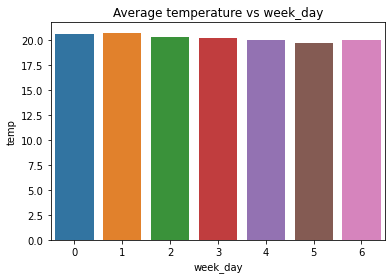

In [106]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

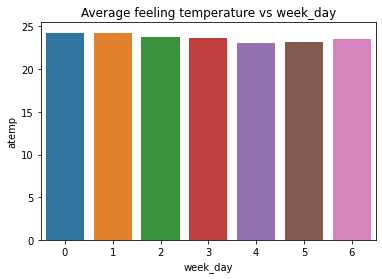

In [107]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

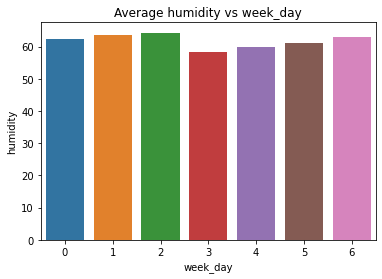

In [108]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

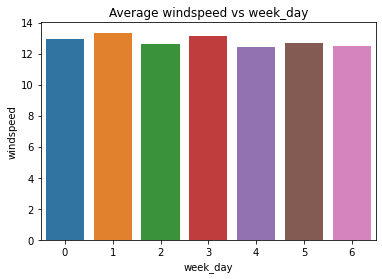

In [109]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

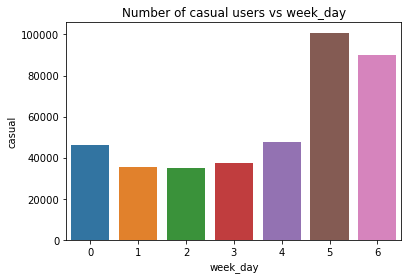

In [110]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

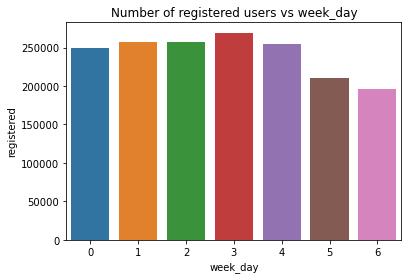

In [111]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

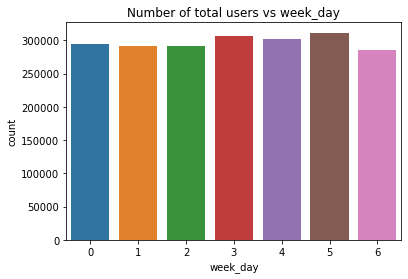

In [112]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by time_of_day

In [113]:
grouping_feature = "time_of_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

,time_of_day,temp,atemp,humidity,windspeed,casual,registered,count
0,Afternoon,22.780175,26.324441,49.853618,15.356595,134752,326737,461489
1,Evening,22.311283,25.778303,52.002741,15.373014,119014,579248,698262
2,Morning,19.112007,22.453147,66.417216,12.287123,79049,494111,573160
3,Night,19.035169,22.443822,68.010426,11.033622,59320,293245,352565


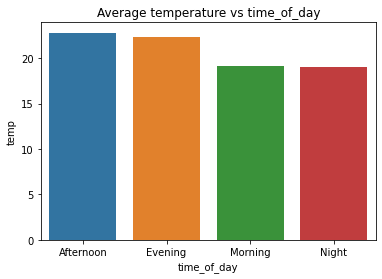

In [114]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

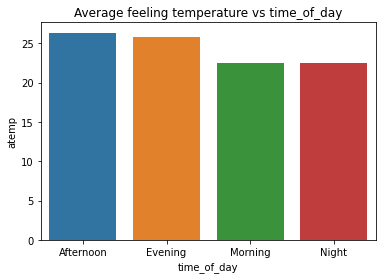

In [115]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

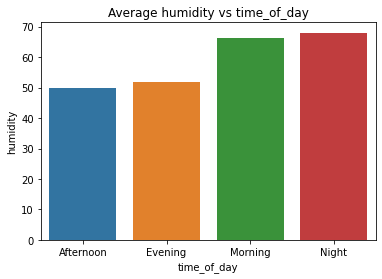

In [116]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

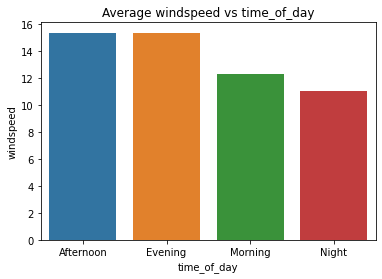

In [117]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

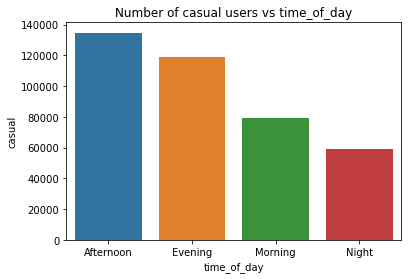

In [118]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

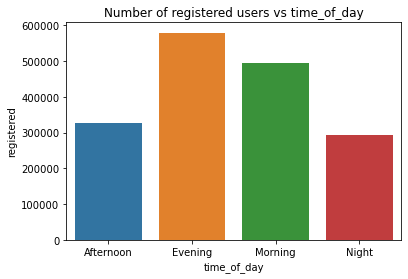

In [119]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

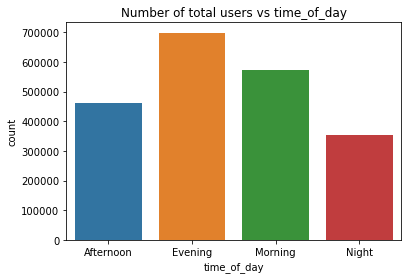

In [120]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Insights :-

1. Evening time has the highest number of bikes rented, followed by Morning and Noon. Night time has lowest number of bikes rented.
2. There are more number of bikes rented by casual users on weekend rather than weekday.
3. There are less number of bikes rented in January, February and March.
4. Around 7,82,000 bikes are rented in 2011. Around 13,03,000 bikes are rented in 2012. It clearly shows that usage and popularity of Yulu bikes increased over the years.
5. Highest number of bikes are rented in type-1 weather, followed by type-2. Type-3 weather saw least number of bikes being rented. (Not considered type-4 weather, as it is a single datapoint)
6. More number of bikes rented on Working day compared to non-working day.
7. More number of bikes rented on non-holiday compared to holiday.
8. Highest number of bikes are rented in type-3 season, followed by type-2 and type-4 seasons. Type-1 weather saw least number of bikes being rented.


## Some more plots

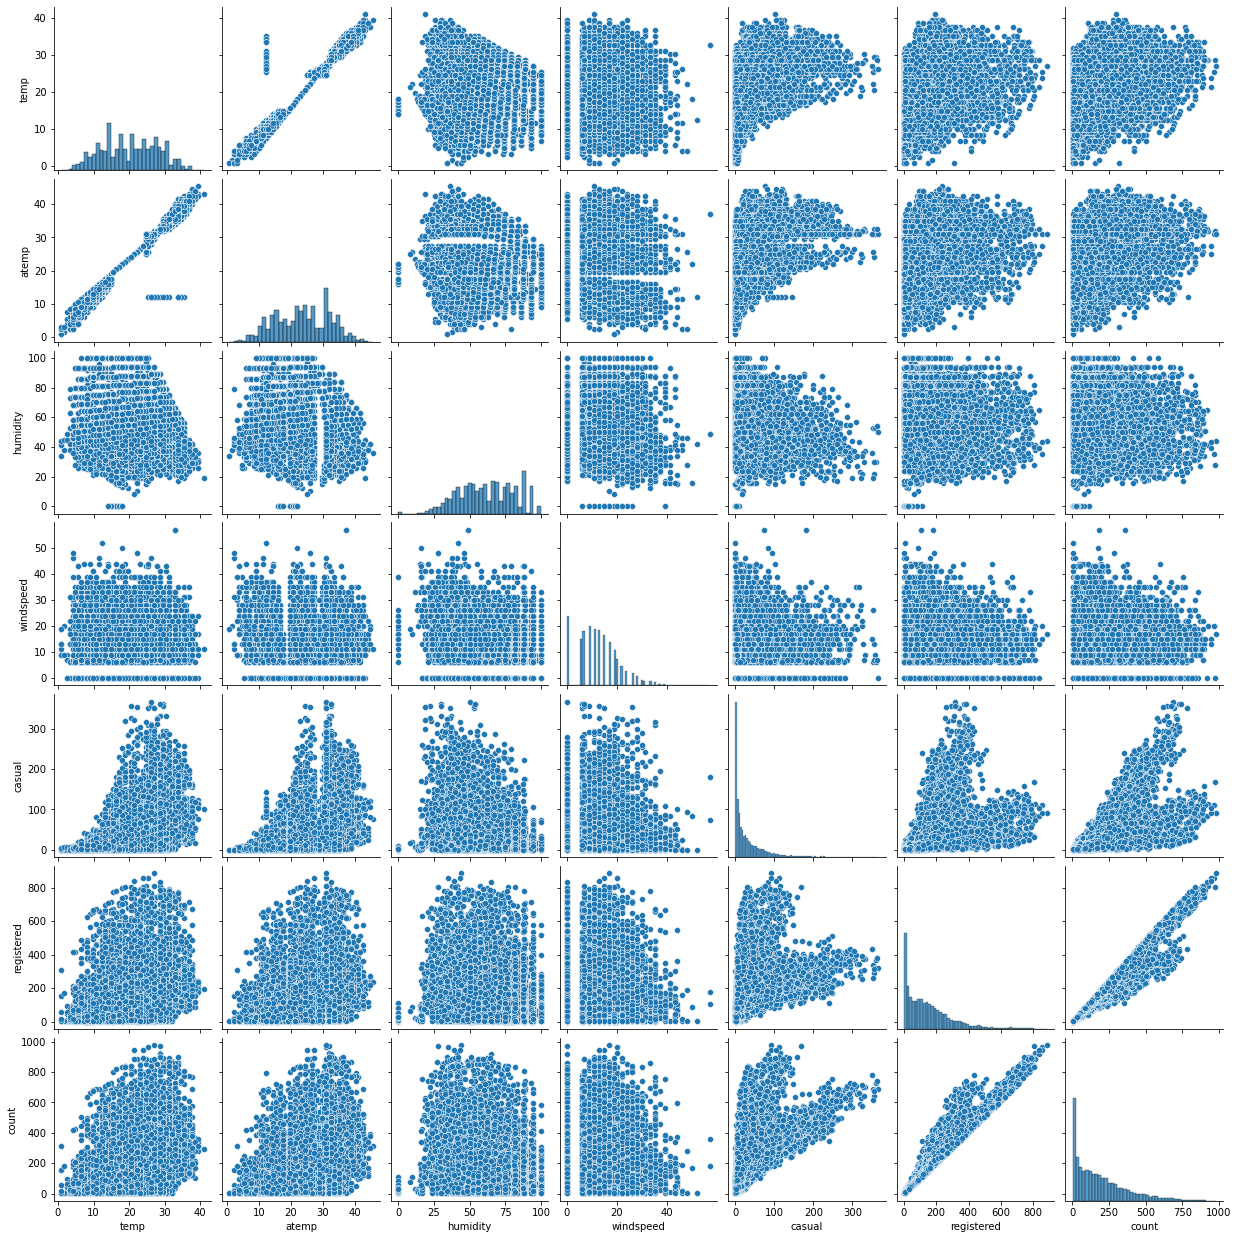

In [121]:
sns.pairplot(df[numerical_features])
plt.show()

In [122]:
df.corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


<AxesSubplot:>

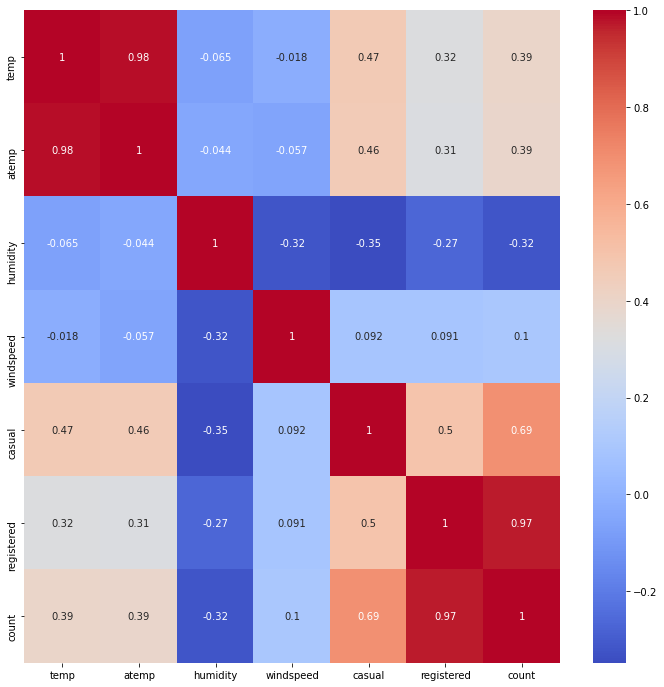

In [123]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

### Insights :-
1. Temperature and Feeling Temperature are highly co-related.
2. casual count and total count are partially co-related.
3. registered count and total count are highly co-related.

## Hypothesis/Statistical Testing

- Note:- *All tests, unless specified, are perfomed with 95% confidence.*

### Utility function

In [124]:
def show_test_result(Ho: str, Ha: str, p_value: float, alpha: float) -> None:
    print(f"P-Value: {p_value}")
    if p_value < alpha:
        print("Reject Null Hypothesis")
        print(Ha)
    else:
        print("Failed to reject Null Hypothesis")
        print(Ho)

### Categorical vs Numerical Tests

#### 1. `Test whether working day has an effect on the number of e-cycle rented`

In [125]:
df.groupby("workingday")['count'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


Note:-

1. There are 2 Categorical values of working day and count is a continous variable. **`So 2 sample t-test can be performed.`**

2.
    - workingday 0 has 3474 datapoints, while workingday 1 has 7412 datapoints.
    - So I take a sample of 3450 datapoints from each of these series and perform the test 5 times.
    - Final result will be the majority result of the test.

**`Homogeniety of Varince`**: Testing homogeniety of variance using **Levene Test**

In [126]:
Ho = "Homogenous Variance"
Ha = "Non-Homogenous Variance"

alpha = 0.05

n = 3450 # sample's size

for iter in range(1, 6):
    working_day = df.loc[df['workingday'] == 1]['count'].sample(n, random_state=iter)
    non_working_day = df.loc[df['workingday'] == 0]['count'].sample(n, random_state=iter)

    test_stat, p_value = stats.levene(working_day, non_working_day)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 0.6231854523507816
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.6759147143718989
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.783589189956283
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.2914844960427821
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.9331734343119197
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------


1. Working Day and Non-working Day Series have homogenous variance.
2. So independent ttest can be performed.

In [127]:
Ho = "Average e-cycle rented on working day = Average e-cycle rented on non-working day"
Ha = "Average e-cycle rented on working day != Average e-cycle rented on non-working day"

alpha = 0.05

n = 3450 # sample's size

for iter in range(1, 6):
    working_day = df.loc[df['workingday'] == 1]['count'].sample(n, random_state=iter)
    non_working_day = df.loc[df['workingday'] == 0]['count'].sample(n, random_state=iter)

    t_stat, p_value = stats.ttest_ind(a = working_day, b = non_working_day)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 0.5124160194780294
Failed to reject Null Hypothesis
Average e-cycle rented on working day = Average e-cycle rented on non-working day
-------------------------------------------------------------------------
P-Value: 0.4079825580482471
Failed to reject Null Hypothesis
Average e-cycle rented on working day = Average e-cycle rented on non-working day
-------------------------------------------------------------------------
P-Value: 0.34037894514812383
Failed to reject Null Hypothesis
Average e-cycle rented on working day = Average e-cycle rented on non-working day
-------------------------------------------------------------------------
P-Value: 0.07030366057076129
Failed to reject Null Hypothesis
Average e-cycle rented on working day = Average e-cycle rented on non-working day
-------------------------------------------------------------------------
P-Value: 0.12996862518271915
Failed to reject Null Hypothesis
Average e-cycle rented on working day = Average e-cycle rented on no

#### 2. `Test whether number of e-cycle rented depend on weather or not`

In [128]:
df.groupby("weather")['count'].describe()

,count,mean,std,min,25%,50%,75%,max
weather,,,,,,,,
1,7192.0,205.236791,187.959566,1.0,48.0,161.0,305.0,977.0
2,2834.0,178.955540,168.366413,1.0,41.0,134.0,264.0,890.0
3,859.0,118.846333,138.581297,1.0,23.0,71.0,161.0,891.0
4,1.0,164.000000,NaN,164.0,164.0,164.0,164.0,164.0


Note:-

1. There are 3 Categorical values of weather (ignoring weather = 4, as it has single datapoint) and count is a continous variable. **`So either ANOVA or Kruskal-Wallis test can be performed.`**
2.
    - weather 1 has 7192 datapoints, weather 2 has 2834 datapoints, and weather 3 has 859 datapoints.
    - So I take a sample of 850 datapoints from each of these series and perform the test 5 times.
    - Final result will be the majority result of the test.

**`Homogeniety of Varince`**: Testing homogeniety of variance using **Levene Test**

In [129]:
Ho = "Homogenous Variance"
Ha = "Non-Homogenous Variance"

alpha = 0.05
n = 850 # sample's size

for iter in range(1, 6):
    weather_1 = df.loc[df['weather'] == 1]['count'].sample(n, random_state=iter)
    weather_2 = df.loc[df['weather'] == 2]['count'].sample(n, random_state=iter)
    weather_3 = df.loc[df['weather'] == 3]['count'].sample(n, random_state=iter)

    test_stat, p_value = stats.levene(weather_1, weather_2, weather_3)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 4.0387330846781874e-21
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 1.763652318600692e-16
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 1.7919032991839836e-19
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 1.4731781345850357e-20
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 3.2248722495544123e-26
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------


As variance is non-homogenous, ANOVA can't be performed (due to violation of Homogeniety of Variance). **`Hence Kruskal-Wallis test will be performed`**

In [130]:
Ho = "No Impact of weather on count of e-cycle rented."
Ha = "There is an Impact of weather on count of e-cycle rented."

alpha = 0.05

n = 850 # sample's size

for iter in range(1, 6):
    weather_1 = df.loc[df['weather'] == 1]['count'].sample(n, random_state=iter)
    weather_2 = df.loc[df['weather'] == 2]['count'].sample(n, random_state=iter)
    weather_3 = df.loc[df['weather'] == 3]['count'].sample(n, random_state=iter)

    kw_stat, p_value = stats.kruskal(weather_1, weather_2, weather_3)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 3.605213835121759e-28
Reject Null Hypothesis
There is an Impact of weather on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 1.2891681776812912e-21
Reject Null Hypothesis
There is an Impact of weather on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 1.3310591758487917e-30
Reject Null Hypothesis
There is an Impact of weather on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 2.4168141524948653e-25
Reject Null Hypothesis
There is an Impact of weather on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 8.932363618103738e-26
Reject Null Hypothesis
There is an Impact of weather on count of e-cycle rented.
-------------------------------------------------------------------------


#### 3. `Test whether number of e-cycle rented depend on season or not`

In [131]:
df.groupby("season")['count'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


Note:-

1. There are 4 Categorical values of season and count is a continous variable. **`So either ANOVA or Kruskal-Wallis test can be performed.`**
2.
    - season 1 has 2686 datapoints, season 2 has 2733 datapoints, season 3 has 2733 datapoints, and season 4 has 2734 datapoints.
    - So I take a sample of 2650 datapoints from each of these series and perform the test 5 times.
    - Final result will be the majority result of the test.

**`Homogeniety of Varince`**: Testing homogeniety of variance using **Levene Test**

In [132]:
Ho = "Homogenous Variance"
Ha = "Non-Homogenous Variance"

alpha = 0.05
n = 2650 # sample's size

for iter in range(1, 6):
    season_1 = df.loc[df['season'] == 1]['count'].sample(n, random_state=iter)
    season_2 = df.loc[df['season'] == 2]['count'].sample(n, random_state=iter)
    season_3 = df.loc[df['season'] == 3]['count'].sample(n, random_state=iter)
    season_4 = df.loc[df['season'] == 4]['count'].sample(n, random_state=iter)

    test_stat, p_value = stats.levene(season_1, season_2, season_3, season_4)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 2.539306632868243e-117
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 8.26252989139275e-118
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 1.5850885385472072e-114
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 1.0516991585976544e-115
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------
P-Value: 3.0939515919351764e-115
Reject Null Hypothesis
Non-Homogenous Variance
-------------------------------------------------------------------------


As variance is non-homogenous, ANOVA can't be performed (due to violation of Homogeniety of Variance). **`Hence Kruskal-Wallis test will be performed`**

In [133]:
Ho = "No Impact of season on count of e-cycle rented."
Ha = "There is an Impact of season on count of e-cycle rented."

alpha = 0.05
n = 2650 # sample's size

for iter in range(1, 6):
    season_1 = df.loc[df['season'] == 1]['count'].sample(n, random_state=iter)
    season_2 = df.loc[df['season'] == 2]['count'].sample(n, random_state=iter)
    season_3 = df.loc[df['season'] == 3]['count'].sample(n, random_state=iter)
    season_4 = df.loc[df['season'] == 4]['count'].sample(n, random_state=iter)

    kw_stat, p_value = stats.kruskal(season_1, season_2, season_3, season_4)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 2.3646270285970655e-149
Reject Null Hypothesis
There is an Impact of season on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 1.0733405727166213e-148
Reject Null Hypothesis
There is an Impact of season on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 2.979702184973995e-147
Reject Null Hypothesis
There is an Impact of season on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 6.998052182613004e-148
Reject Null Hypothesis
There is an Impact of season on count of e-cycle rented.
-------------------------------------------------------------------------
P-Value: 9.935231196805822e-147
Reject Null Hypothesis
There is an Impact of season on count of e-cycle rented.
-------------------------------------------------------------------------


#### 4. `Test whether holiday has an effect on the number of e-cycle rented`

In [134]:
df.groupby("holiday")['count'].describe()

,count,mean,std,min,25%,50%,75%,max
holiday,,,,,,,,
0,10575.0,191.741655,181.513131,1.0,43.0,145.0,283.0,977.0
1,311.0,185.877814,168.300531,1.0,38.5,133.0,308.0,712.0


Note:-

1. There are 2 Categorical values of holiday and count is a continous variable. **`So 2 sample t-test can be performed.`**

2.
    - holiday 0 has 10575 datapoints, while holiday 1 has 311 datapoints.
    - So I take a sample of 300 datapoints from each of these series and perform the test 5 times.
    - Final result will be the majority result of the test.

**`Homogeniety of Varince`**: Testing homogeniety of varince using **Levene Test**

In [135]:
Ho = "Homogenous Variance"
Ha = "Non-Homogenous Variance"

alpha = 0.05

n = 300 # sample's size

for iter in range(1, 6):
    holiday = df.loc[df['holiday'] == 1]['count'].sample(n, random_state=iter)
    non_holiday = df.loc[df['holiday'] == 0]['count'].sample(n, random_state=iter)

    test_stat, p_value = stats.levene(holiday, non_holiday)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 0.7492932196185781
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.8455342854410537
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.8970185715392575
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.29202009686303654
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------
P-Value: 0.8158907872677091
Failed to reject Null Hypothesis
Homogenous Variance
-------------------------------------------------------------------------


1. Holiday and Non-holiday Series have homogenous variance.
2. So independent ttest can be performed.

In [136]:
Ho = "Average e-cycle rented on holiday = Average e-cycle rented on non-holiday"
Ha = "Average e-cycle rented on holiday != Average e-cycle rented on non-holiday"

alpha = 0.05

n = 300 # sample's size

for iter in range(1, 6):
    holiday = df.loc[df['holiday'] == 1]['count'].sample(n, random_state=iter)
    non_holiday = df.loc[df['holiday'] == 0]['count'].sample(n, random_state=iter)

    t_stat, p_value = stats.ttest_ind(a = holiday, b = non_holiday)
    show_test_result(Ho, Ha, p_value, alpha)
    print('-------------------------------------------------------------------------')

P-Value: 0.224051290524508
Failed to reject Null Hypothesis
Average e-cycle rented on holiday = Average e-cycle rented on non-holiday
-------------------------------------------------------------------------
P-Value: 0.4232092947242524
Failed to reject Null Hypothesis
Average e-cycle rented on holiday = Average e-cycle rented on non-holiday
-------------------------------------------------------------------------
P-Value: 0.7329718396405973
Failed to reject Null Hypothesis
Average e-cycle rented on holiday = Average e-cycle rented on non-holiday
-------------------------------------------------------------------------
P-Value: 0.49640941257748916
Failed to reject Null Hypothesis
Average e-cycle rented on holiday = Average e-cycle rented on non-holiday
-------------------------------------------------------------------------
P-Value: 0.8016318145591698
Failed to reject Null Hypothesis
Average e-cycle rented on holiday = Average e-cycle rented on non-holiday
-----------------------------

### Insights

1. There is no significance difference in average number bikes rented on working-day vs non-working-day.
2. There is a significant impact of weather on number of bikes being rented.
3. There is a significant impact of season on number of bikes being rented.
4. There is no significance difference in average number bikes rented on holiday vs non-holiday.

### Categorical vs Categorical Tests

In [137]:
categorical_features

['season', 'holiday', 'workingday', 'weather']

#### 1. `To check if Weather is dependent on the season`

In [138]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [139]:
df['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

Note:-

1. Both season and weather are categorical columns. **`So Chi-squared test can be performed.`**

In [140]:
temp_df = df.loc[df['weather'] != 4] # not conidering season 4 as it has single datapoint
observed_matrix = pd.crosstab(index=temp_df['weather'], columns=temp_df['season'])

observed_matrix

season,1,2,3,4
weather,,,,
1,1759,1801,1930,1702
2,715,708,604,807
3,211,224,199,225


- Each cell of observed matrix has value > 5.
- Hence performing chi-squared test

In [141]:
Ho = "Weather doesn't depend on the Season"
Ha = "Weather depends on Season"
alpha = 0.05

chi_stat, p_value, dof, expected_matrix = stats.chi2_contingency(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 2.8260014509929403e-08
Reject Null Hypothesis
Weather depends on Season


#### 2. `To check if workingday is dependent on the weather`

In [142]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [143]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

Note:-

1. Both workingday and weather are categorical columns. **`So Chi-squared test can be performed.`**

In [144]:
temp_df = df.loc[df['weather'] != 4]
observed_matrix = pd.crosstab(index=temp_df['weather'], columns=temp_df['workingday'])

observed_matrix

workingday,0,1
weather,,
1,2353,4839
2,897,1937
3,224,635


- Each cell of observed matrix has value > 5.
- Hence performing chi-squared test

In [145]:
Ho = "Weather doesn't affect the Working Day"
Ha = "Weather affects the Working Day"
alpha = 0.05

chi_stat, p_value, dof, expected_matrix = stats.chi2_contingency(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 0.00039111646797425055
Reject Null Hypothesis
Weather affects the Working Day


#### 3. `To check if holiday is dependent on the weather`

In [146]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [147]:
df['holiday'].value_counts()

0    10575
1      311
Name: holiday, dtype: int64

Note:-

1. Both holiday and weather are categorical columns. **`So Chi-squared test can be performed.`**

In [148]:
temp_df = df.loc[df['weather'] != 4]
observed_matrix = pd.crosstab(index=temp_df['weather'], columns=temp_df['holiday'])

observed_matrix

holiday,0,1
weather,,
1,6988,204
2,2742,92
3,844,15


- Each cell of observed matrix has value > 5.
- Hence performing chi-squared test

In [149]:
Ho = "Weather doesn't affect the Holiday"
Ha = "Weather affects the Holiday"
alpha = 0.05

chi_stat, p_value, dof, expected_matrix = stats.chi2_contingency(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 0.06798312319627714
Failed to reject Null Hypothesis
Weather doesn't affect the Holiday


#### 4. `To check if workingday is dependent on the season`

In [150]:
df['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [151]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

Note:-

1. Both workingday and season are categorical columns. **`So Chi-squared test can be performed.`**

In [152]:
observed_matrix = pd.crosstab(index=df['season'], columns=df['workingday'])
observed_matrix

workingday,0,1
season,,
1,858,1828
2,840,1893
3,888,1845
4,888,1846


- Each cell of observed matrix has value > 5.
- Hence performing chi-squared test

In [153]:
Ho = "Season doesn't affect the Working Day"
Ha = "Season affects the Working Day"
alpha = 0.05

chi_stat, p_value, dof, expected_matrix = stats.chi2_contingency(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 0.4626148207703564
Failed to reject Null Hypothesis
Season doesn't affect the Working Day


#### 5. `To check if holiday is dependent on the season`

In [154]:
df['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [155]:
df['holiday'].value_counts()

0    10575
1      311
Name: holiday, dtype: int64

Note:-

1. Both holiday and season are categorical columns. **`So Chi-squared test can be performed.`**

In [156]:
observed_matrix = pd.crosstab(index=df['season'], columns=df['holiday'])
observed_matrix

holiday,0,1
season,,
1,2615,71
2,2685,48
3,2637,96
4,2638,96


- Each cell of observed matrix has value > 5.
- Hence performing chi-squared test

In [157]:
Ho = "Season doesn't affect the Holiday"
Ha = "Season affects the Holiday"
alpha = 0.05

chi_stat, p_value, dof, expected_matrix = stats.chi2_contingency(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 0.00011455163312609901
Reject Null Hypothesis
Season affects the Holiday


#### 6. `To check if workingday is dependent on the holiday`

In [158]:
df['holiday'].value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [159]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

Note:-

1. Both workingday and holiday are categorical columns. **`So Chi-squared test can be performed.`**

In [160]:
observed_matrix = pd.crosstab(index=df['holiday'], columns=df['workingday'])
observed_matrix

workingday,0,1
holiday,,
0,3163,7412
1,311,0


- Not Each cell of observed matrix has value > 5.
- Hence can't perform chi-squared test.
- One alternative is to perform Fischer's Exact Test

In [161]:
Ho = "Season doesn't affect the Working Day"
Ha = "Season affects the Working Day"
alpha = 0.05

fe_stat, p_value = stats.fisher_exact(observed_matrix)
show_test_result(Ho, Ha, p_value, alpha)

P-Value: 2.880296018996686e-159
Reject Null Hypothesis
Season affects the Working Day


# Summarizing Insights and Recommendations

## Summarizing Insights

1. **Time of Day Analysis:**
   - **Highest Rentals:** Evening time has the highest number of bikes rented.
   - **Moderate Rentals:** Morning and Noon times follow in the number of rentals.
   - **Lowest Rentals:** Night time has the lowest number of bikes rented.

2. **User Type and Day of the Week:**
   - **Casual Users:** There are more bikes rented by casual users on weekends compared to weekdays.

3. **Seasonal Trends:**
   - **Winter Rentals:** Fewer bikes are rented in January, February, and March.

4. **Yearly Trends:**
   - **2011 Rentals:** Approximately 782,000 bikes were rented in 2011.
   - **2012 Rentals:** Approximately 1,303,000 bikes were rented in 2012, showing a significant increase in usage and popularity of Yulu bikes over the years.

5. **Weather Impact:**
   - **Highest Rentals:** Clear weather (type 1) has the highest number of bike rentals.
   - **Moderate Rentals:** Misty weather (type 2) follows in the number of rentals.
   - **Lowest Rentals:** Light snow and light rain (type 3) weather saw the least number of bikes being rented (excluding type 4 weather due to it being a single datapoint).

6. **Working Day Impact:**
   - **Higher Rentals:** More bikes are rented on working days compared to non-working days.

7. **Holiday Impact:**
   - **Higher Rentals:** More bikes are rented on non-holidays compared to holidays.

8. **Seasonal Impact:**
   - **Highest Rentals:** Fall (type 3 season) has the highest number of bike rentals.
   - **Moderate Rentals:** Followed by summer (type 2 season) and winter (type 4 season).
   - **Lowest Rentals:** Spring (type 1 season) saw the least number of bike rentals.

### Hypothesis Testing Insights:

1. **Working Day vs. Non-Working Day:**
   - There is no significant difference in the average number of bikes rented on working days compared to non-working days.

2. **Weather Impact:**
   - There is a significant impact of weather on the number of bikes being rented.

3. **Season Impact:**
   - There is a significant impact of the season on the number of bikes being rented.

4. **Holiday vs. Non-Holiday:**
   - There is no significant difference in the average number of bikes rented on holidays compared to non-holidays.


## Recommendations

1. **Optimize Evening Availability:**
   - **Increase Fleet During Peak Hours:** Since the evening has the highest number of rentals, ensure that more bikes are available during these hours to meet the demand. Consider deploying additional bikes or ensuring rapid turnaround times for bikes returned earlier in the day.

2. **Weekend Promotions for Casual Users:**
   - **Target Weekend Casual Users:** Since casual users rent more bikes on weekends, implement targeted marketing campaigns or promotions for weekends. Discounts or loyalty programs could further boost weekend rentals.

3. **Seasonal Adjustments:**
   - **Prepare for Winter:** Given the lower rental rates in winter (January, February, March), consider offering special promotions or services (e.g., heated seats or weather-resistant bikes) to encourage usage during these months.

4. **Expand Capacity:**
   - **Scale Up Operations:** The significant increase in bike rentals from 2011 to 2012 indicates growing popularity. Plan for continuous expansion of the fleet and infrastructure to meet the rising demand and avoid shortages.

5. **Weather-Related Strategies:**
   - **Improve Weather Readiness:** Since clear weather (type 1) sees the highest rentals, and misty weather (type 2) also maintains moderate rentals, ensure bikes are well-maintained and ready for diverse weather conditions. Provide users with real-time weather updates and safety tips through the app.

6. **Enhance Working Day Utilization:**
   - **Corporate Partnerships:** Since more bikes are rented on working days, collaborate with companies to offer bike-sharing as a part of corporate wellness programs or provide dedicated bikes for office commutes.

7. **Holiday Specials:**
   - **Non-Holiday Incentives:** To address the lower rentals on holidays, introduce special holiday promotions or events to encourage usage. Highlight the benefits of biking for leisure during holidays.

8. **Seasonal Promotions:**
   - **Leverage Seasonal Popularity:** Since fall (type 3) has the highest rentals, followed by summer (type 2) and winter (type 4), plan seasonal campaigns that promote biking in these favorable seasons. Introduce seasonal passes or packages to attract consistent usage.

9. **Improve Data-Driven Decision Making:**
   - **Continuous Analysis:** Regularly monitor and analyze rental patterns to adapt strategies quickly. Use data analytics to forecast demand and optimize bike availability accordingly.

10. **Enhance User Experience:**
    - **App Improvements:** Integrate features in the app that cater to the insights, such as recommending the best times to rent, providing weather forecasts, and offering route suggestions based on historical data.

*By implementing these recommendations, Yulu can optimize bike availability, enhance user experience, and drive higher rentals throughout the year.*
